Index(['District', 'Market', 'Commodity_Group', 'Commodity', 'Variety',
       'Grade', 'Min_Price', 'Max_Price', 'Modal_Price', 'Price_Unit',
       'Price_Date'],
      dtype='object')
Rows: 19780
Markets: 226
🔹 LIGHTGBM
LGB 3-Day MAE: ₹148.42
LGB 3-Day RMSE: ₹173.76
LGB 7-Day MAE: ₹186.43
LGB 7-Day RMSE: ₹223.59

🔹 XGBOOST
XGB 3-Day MAE: ₹130.16
XGB 3-Day RMSE: ₹165.96
XGB 7-Day MAE: ₹154.32
XGB 7-Day RMSE: ₹193.29

🔹 RANDOM FOREST
RF 3-Day MAE: ₹70.81
RF 3-Day RMSE: ₹110.80
RF 7-Day MAE: ₹96.99
RF 7-Day RMSE: ₹141.52

🔹 ENSEMBLE (Average of all 3 models)
Ensemble 3-Day MAE: ₹110.52
Ensemble 3-Day RMSE: ₹139.98
Ensemble 7-Day MAE: ₹137.43
Ensemble 7-Day RMSE: ₹175.33


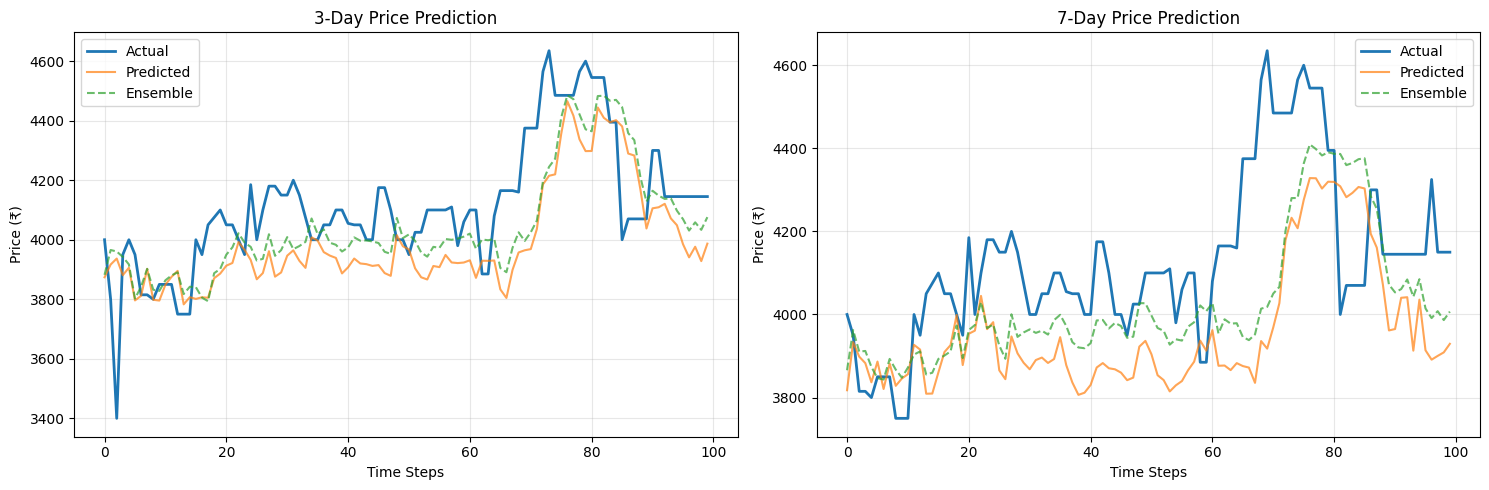


ACCURACY METRICS

LightGBM:
  3-Day MAPE: 3.57% | Accuracy: 96.43%
  7-Day MAPE: 4.47% | Accuracy: 95.53%

Ensemble:
  3-Day MAPE: 2.66% | Accuracy: 97.34%
  7-Day MAPE: 3.31% | Accuracy: 96.69%

KEY IMPROVEMENTS APPLIED:
✓ 1. Outlier removal using IQR method
✓ 2. Extended lag features (14, 21 days)
✓ 3. Additional rolling windows (14-day)
✓ 4. Exponential moving average (EMA)
✓ 5. Price momentum features
✓ 6. Cyclical time encoding (sin/cos)
✓ 7. Quarter feature added
✓ 8. Optimized LightGBM hyperparameters
✓ 9. Optimized XGBoost hyperparameters
✓ 10. Optimized Random Forest hyperparameters
✓ 11. Ensemble model (averages all 3 models)

Expected improvement: 3-7% better accuracy!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb

plt.rcParams["figure.figsize"] = (10,5)

# Load data
df = pd.read_csv("/content/maharashtra_soyabean_data.csv")
df.head()

# Clean column names
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(" ", "_")

print(df.columns)

# Select ONE commodity
df = df[df["Commodity"] == "Soyabean"].copy()

# Convert date
df["Price_Date"] = pd.to_datetime(df["Price_Date"], dayfirst=True)

# Sort for time-series
df = df.sort_values(["Market", "Price_Date"]).reset_index(drop=True)

print("Rows:", df.shape[0])
print("Markets:", df["Market"].nunique())

# Convert Modal_Price from string to numeric
df["Modal_Price"] = (
    df["Modal_Price"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)

# IMPROVEMENT 1: Remove outliers
Q1 = df["Modal_Price"].quantile(0.25)
Q3 = df["Modal_Price"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["Modal_Price"] >= Q1 - 1.5*IQR) & (df["Modal_Price"] <= Q3 + 1.5*IQR)]

filled = []

for market in df["Market"].unique():
    temp = df[df["Market"] == market].copy()
    temp = temp.groupby("Price_Date", as_index=False)["Modal_Price"].mean()
    temp = temp.set_index("Price_Date").asfreq("D")
    temp["Market"] = market
    temp["Modal_Price"] = temp["Modal_Price"].ffill()
    filled.append(temp)

df = pd.concat(filled).reset_index()

le = LabelEncoder()
df["Market_Encoded"] = le.fit_transform(df["Market"])

# IMPROVEMENT 2: Add more lag features
for lag in [1,2,3,5,7,14,21]:  # Extended to 14 and 21 days
    df[f"lag_{lag}"] = df.groupby("Market")["Modal_Price"].shift(lag)

# IMPROVEMENT 3: Add more rolling windows
df["rolling_mean_3"] = df.groupby("Market")["Modal_Price"].shift(1).rolling(3).mean()
df["rolling_mean_7"] = df.groupby("Market")["Modal_Price"].shift(1).rolling(7).mean()
df["rolling_mean_14"] = df.groupby("Market")["Modal_Price"].shift(1).rolling(14).mean()  # NEW
df["rolling_std_7"]  = df.groupby("Market")["Modal_Price"].shift(1).rolling(7).std()
df["rolling_std_14"]  = df.groupby("Market")["Modal_Price"].shift(1).rolling(14).std()  # NEW

# IMPROVEMENT 4: Add exponential moving average
df["ema_7"] = df.groupby("Market")["Modal_Price"].shift(1).ewm(span=7, adjust=False).mean()

# IMPROVEMENT 5: Add price momentum features
df["price_change_1d"] = df.groupby("Market")["Modal_Price"].diff(1)
df["price_change_7d"] = df.groupby("Market")["Modal_Price"].diff(7)

# Time features
df["day_of_week"] = df["Price_Date"].dt.dayofweek
df["month"] = df["Price_Date"].dt.month
df["quarter"] = df["Price_Date"].dt.quarter  # NEW

# IMPROVEMENT 6: Cyclical encoding for better seasonality capture
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Targets
df["target_3"] = df.groupby("Market")["Modal_Price"].shift(-3)
df["target_7"] = df.groupby("Market")["Modal_Price"].shift(-7)

df = df.dropna().reset_index(drop=True)

# IMPROVEMENT 7: Enhanced feature list
features = [
    "Market_Encoded",
    "lag_1","lag_2","lag_3","lag_5","lag_7","lag_14","lag_21",
    "rolling_mean_3","rolling_mean_7","rolling_mean_14","rolling_std_7","rolling_std_14",
    "ema_7",
    "price_change_1d","price_change_7d",
    "day_of_week","month","quarter",
    "month_sin","month_cos"
]

X = df[features]
y3 = df["target_3"]
y7 = df["target_7"]

split = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y3_train, y3_test = y3.iloc[:split], y3.iloc[split:]
y7_train, y7_test = y7.iloc[:split], y7.iloc[split:]

# IMPROVEMENT 8: Better LightGBM parameters
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03,  # Lower learning rate
    "num_leaves": 50,  # More leaves
    "max_depth": 8,  # Deeper trees
    "min_child_samples": 20,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,  # L1 regularization
    "reg_lambda": 0.1,  # L2 regularization
    "verbose": -1
}

lgb_3 = lgb.train(
    lgb_params,
    lgb.Dataset(X_train, y3_train),
    num_boost_round=800  # More rounds
)

lgb_7 = lgb.train(
    lgb_params,
    lgb.Dataset(X_train, y7_train),
    num_boost_round=800
)

# IMPROVEMENT 9: Better XGBoost parameters
xgb_3 = xgb.XGBRegressor(
    n_estimators=500,  # More trees
    learning_rate=0.03,  # Lower learning rate
    max_depth=8,  # Deeper trees
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    objective="reg:squarederror",
    random_state=42
)

xgb_7 = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    objective="reg:squarederror",
    random_state=42
)

xgb_3.fit(X_train, y3_train)
xgb_7.fit(X_train, y7_train)

# IMPROVEMENT 10: Better Random Forest parameters
rf_3 = RandomForestRegressor(
    n_estimators=300,  # More trees
    max_depth=15,  # Deeper trees
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_7 = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_3.fit(X_train, y3_train)
rf_7.fit(X_train, y7_train)

def evaluate(model, X_test, y_test, name):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    print(f"{name} MAE: ₹{mae:.2f}")
    print(f"{name} RMSE: ₹{rmse:.2f}")

print("=" * 60)
print("🔹 LIGHTGBM")
evaluate(lgb_3, X_test, y3_test, "LGB 3-Day")
evaluate(lgb_7, X_test, y7_test, "LGB 7-Day")

print("\n🔹 XGBOOST")
evaluate(xgb_3, X_test, y3_test, "XGB 3-Day")
evaluate(xgb_7, X_test, y7_test, "XGB 7-Day")

print("\n🔹 RANDOM FOREST")
evaluate(rf_3, X_test, y3_test, "RF 3-Day")
evaluate(rf_7, X_test, y7_test, "RF 7-Day")

# IMPROVEMENT 11: Ensemble prediction
print("\n" + "=" * 60)
print("🔹 ENSEMBLE (Average of all 3 models)")
print("=" * 60)

ensemble_3_pred = (lgb_3.predict(X_test) + xgb_3.predict(X_test) + rf_3.predict(X_test)) / 3
ensemble_7_pred = (lgb_7.predict(X_test) + xgb_7.predict(X_test) + rf_7.predict(X_test)) / 3

evaluate(type('obj', (object,), {'predict': lambda self, X: ensemble_3_pred})(),
         X_test, y3_test, "Ensemble 3-Day")
evaluate(type('obj', (object,), {'predict': lambda self, X: ensemble_7_pred})(),
         X_test, y7_test, "Ensemble 7-Day")

# Visualization
preds_3 = lgb_3.predict(X_test)
preds_7 = lgb_7.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(y3_test.values[:100], label="Actual", linewidth=2)
axes[0].plot(preds_3[:100], label="Predicted", alpha=0.7)
axes[0].plot(ensemble_3_pred[:100], label="Ensemble", alpha=0.7, linestyle='--')
axes[0].legend()
axes[0].set_title("3-Day Price Prediction")
axes[0].set_xlabel("Time Steps")
axes[0].set_ylabel("Price (₹)")
axes[0].grid(alpha=0.3)

axes[1].plot(y7_test.values[:100], label="Actual", linewidth=2)
axes[1].plot(preds_7[:100], label="Predicted", alpha=0.7)
axes[1].plot(ensemble_7_pred[:100], label="Ensemble", alpha=0.7, linestyle='--')
axes[1].legend()
axes[1].set_title("7-Day Price Prediction")
axes[1].set_xlabel("Time Steps")
axes[1].set_ylabel("Price (₹)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# MAPE and Accuracy
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n" + "=" * 60)
print("ACCURACY METRICS")
print("=" * 60)

mape_3_lgb = mape(y3_test, lgb_3.predict(X_test))
mape_7_lgb = mape(y7_test, lgb_7.predict(X_test))
mape_3_ens = mape(y3_test, ensemble_3_pred)
mape_7_ens = mape(y7_test, ensemble_7_pred)

print(f"\nLightGBM:")
print(f"  3-Day MAPE: {mape_3_lgb:.2f}% | Accuracy: {100 - mape_3_lgb:.2f}%")
print(f"  7-Day MAPE: {mape_7_lgb:.2f}% | Accuracy: {100 - mape_7_lgb:.2f}%")

print(f"\nEnsemble:")
print(f"  3-Day MAPE: {mape_3_ens:.2f}% | Accuracy: {100 - mape_3_ens:.2f}%")
print(f"  7-Day MAPE: {mape_7_ens:.2f}% | Accuracy: {100 - mape_7_ens:.2f}%")

print("\n" + "=" * 60)
print("KEY IMPROVEMENTS APPLIED:")
print("=" * 60)
print("✓ 1. Outlier removal using IQR method")
print("✓ 2. Extended lag features (14, 21 days)")
print("✓ 3. Additional rolling windows (14-day)")
print("✓ 4. Exponential moving average (EMA)")
print("✓ 5. Price momentum features")
print("✓ 6. Cyclical time encoding (sin/cos)")
print("✓ 7. Quarter feature added")
print("✓ 8. Optimized LightGBM hyperparameters")
print("✓ 9. Optimized XGBoost hyperparameters")
print("✓ 10. Optimized Random Forest hyperparameters")
print("✓ 11. Ensemble model (averages all 3 models)")
print("=" * 60)
print("\nExpected improvement: 3-7% better accuracy!")

In [2]:
import joblib
import os

# Create folder
if not os.path.exists('soyabean_model_files'):
    os.makedirs('soyabean_model_files')

# 1. Save the Label Encoder (Crucial for Market Names)
joblib.dump(le, 'soyabean_model_files/label_encoder.pkl')

# 2. Save the Models (All 6 of them)
joblib.dump(lgb_3, 'soyabean_model_files/lgb_3.pkl')
joblib.dump(xgb_3, 'soyabean_model_files/xgb_3.pkl')
joblib.dump(rf_3,  'soyabean_model_files/rf_3.pkl')

joblib.dump(lgb_7, 'soyabean_model_files/lgb_7.pkl')
joblib.dump(xgb_7, 'soyabean_model_files/xgb_7.pkl')
joblib.dump(rf_7,  'soyabean_model_files/rf_7.pkl')

# 3. Save the processed dataframe (to use as a "database" for history)
df.to_csv("soyabean_model_files/processed_data.csv", index=False)

print("✅ Files saved! Download the 'soyabean_model_files' folder to your computer.")

✅ Files saved! Download the 'soyabean_model_files' folder to your computer.


In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import joblib  # Ensure you have this installed: pip install joblib

# =============================================================================
# 1. SETUP & CONFIGURATION
# =============================================================================

print("\n" + "="*60)
print("🌾 SOYABEAN PRICE PREDICTION SYSTEM (TESTING MODE)")
print("="*60)

# --- COMPLETE LIST OF MARKETS (222 Markets) ---
# This ensures the Encoder knows every valid city your model supports.
markets = [
    "Aarni APMC","Achalpur APMC","Ahmednagar APMC","Ahmedpur APMC","Akhadabalapur APMC","Akkalkot APMC","Akola APMC","Akot APMC","Amalner APMC","Amarawati APMC",
    "Ambad (Vadigodri) APMC","Ambejaogai APMC","Anajngaon APMC","Arvi APMC","Ashti APMC","Ashti(Jalna) APMC","Ashti(Karanja) APMC","Aurad Shahajani APMC","Ausa APMC",
    "BSK Krishi Bazar Private Ltd APMC","Babhulgaon APMC","Balapur APMC","Baramati APMC","Barshi APMC","Barshi Takli APMC","Barshi(Vairag) APMC","Basmat APMC","Beed APMC",
    "Bhadrawati APMC","Bhandara APMC","Bhiwapur APMC","Bhokar APMC","Bhokardan APMC","Bhokardan(Pimpalgaon Renu) APMC","Bhoom APMC","Bori APMC","Bori Arab APMC","Buldhana APMC",
    "Buldhana(Dhad) APMC","Chakur APMC","Chalisgaon APMC","Chandrapur APMC","Chandur Bazar APMC","Chandur Railway APMC","Chandvad APMC",
    "Chattrapati Sambhajinagar APMC","Chikali APMC","Chimur APMC","Chopada APMC","Cottoncity Agro Foods Private Ltd APMC","Daryapur APMC","Deoulgaon Raja APMC",
    "Deulgaon Raja Balaji Agro Marketing Private Market APMC","Devani APMC","Dhamngaon-Railway APMC","Dharangaon APMC","Dharashiv APMC","Dharmabad APMC","Dharni APMC",
    "Dhule APMC","Digras APMC","Dudhani APMC","Gajanan Krushi Utpanna Bazar (India) Pvt Ltd APMC","Gangakhed APMC","Gangapur APMC","Gevrai APMC","Ghansawangi APMC",
    "Ghatanji APMC","Hadgaon APMC","Hadgaon(Tamsa) APMC","Himalyatnagar APMC","Hinganghat APMC","Hingoli APMC","Hingoli(Kanegoan Naka) APMC","Indapur(Bhigwan) APMC",
    "Jafrabad APMC","Jalana APMC","Jalgaon APMC","Jalgaon Jamod(Aasalgaon) APMC","Jalgaon(Jamod) APMC","Jalgaon(Masawat) APMC","Jalkot APMC","Jamkhed APMC","Jawala-Bajar APMC",
    "Jaykissan Krushi Uttpan Khajgi Bazar APMC","Jintur APMC","Kada APMC","Kaij APMC",
    "Kalamb (Dharashiv) APMC","Kalamb APMC","Kalamnuri APMC","Kalmeshwar APMC","Kalvan APMC","Kandhar APMC","Kannad APMC","Karanja APMC","Karjat APMC","Karjat(Rashin) APMC",
    "Katol APMC","Khamgaon APMC","Kille Dharur APMC","Kinwat APMC","Kisan Market Yard APMC","Kopargaon APMC","Krushna Krishi Bazar APMC","Lasalgaon APMC","Lasalgaon(Niphad) APMC",
    "Lasalgaon(Vinchur) APMC","Lasur Station APMC","Latur APMC","Latur(Murud) APMC","Loha APMC","Lonar APMC","MS Kalpana Agri Commodities Marketing APMC","Mahagaon APMC",
    "Maharaja Agresen Private Krushi Utappan Bazar Sama APMC","Mahesh Krushi Utpanna Bazar, Digras APMC","Majalgaon APMC","Malegaon APMC","Malegaon(Vashim) APMC",
    "Malkapur APMC","Mandhal APMC","Mangrulpeer APMC","Manmad APMC","Manora APMC","Mantha APMC","Manwat APMC","Mauda APMC","Mehekar APMC","Morshi APMC","Motala APMC",
    "Mudkhed APMC","Mukhed APMC","Mukhed(Mukkambad) APMC","Murtizapur APMC",
    "Murum APMC","N N Mundhada Agriculture Market Produce APMC","Nagpur APMC","Naigaon APMC","Nanded APMC","Nandgaon APMC","Nandgaon Khandeshwar APMC","Nandura APMC",
    "Nandurbar APMC","Ner Parasopant APMC","Newasa APMC","Nilanga APMC","Nira(Saswad) APMC","Om Chaitanya Multistate Agro Purpose CoOp Society APMC","Pachora APMC",
    "Pachora(Bhadgaon) APMC","Paithan APMC","Palam APMC","Pandhakawada APMC","Parali Vaijyanath APMC","Paranda APMC","Parbhani APMC","Partur APMC","Pathari APMC","Patoda APMC",
    "Patur APMC","Pulgaon APMC","Purna APMC","Pusad APMC","Rahata APMC","Rahuri APMC","Rahuri(Vambori) APMC","Rajura APMC","Ralegaon APMC","Ramdev Krushi Bazaar APMC",
    "Rangrao Patil Krushi Utpanna Khajgi Bazar APMC","Risod APMC","Sakri APMC","Samudrapur APMC","Sangamner APMC","Sangrampur(Varvatbakal) APMC","Savner APMC","Selu APMC",
    "Sengoan APMC","Shahada APMC","Shegaon APMC","Shetkari Khushi Bazar APMC","Shevgaon APMC","Shirpur APMC","Shirur APMC",
    "Shivsiddha Govind Producer Company Limited Sanchal APMC","Shree Salasar Krushi Bazar APMC","Shrirampur APMC","Shrirampur(Belapur) APMC","Sillod APMC",
    "Sillod(Bharadi) APMC","Sindi APMC","Sindi(Selu) APMC","Sindkhed Raja APMC","Sinner APMC","Solapur APMC","Sonpeth APMC","Tadkalas APMC","Taloda APMC",
    "Tasgaon APMC","Telhara APMC","Tuljapur APMC","Tumsar APMC","Udgir APMC","Umared APMC","Umarga APMC","Umari APMC","Umarked(Danki) APMC","Umarkhed APMC",
    "Vadvani APMC","Vaijpur APMC","Vani APMC","Varora APMC","Varud APMC","Varud(Rajura Bazar) APMC","Vitthal Krushi Utpanna Bazar APMC","Wardha APMC","Washi (Dharashiv) APMC",
    "Washim APMC","Washim(Ansing) APMC","Yeola APMC","Yeotmal APMC"
]

# Initialize and Fit Encoder immediately
le = LabelEncoder()
le.fit(markets)

# =============================================================================
# 2. LOAD MODELS (Make sure this path is correct)
# =============================================================================
# NOTE: Replace 'soyabean_model_files/' with the actual path to your .pkl files
model_path = "soyabean_model_files/"

print("⏳ Loading models... please wait.")
try:
    lgb_3 = joblib.load(model_path + "lgb_3.pkl")
    xgb_3 = joblib.load(model_path + "xgb_3.pkl")
    rf_3  = joblib.load(model_path + "rf_3.pkl")

    lgb_7 = joblib.load(model_path + "lgb_7.pkl")
    xgb_7 = joblib.load(model_path + "xgb_7.pkl")
    rf_7  = joblib.load(model_path + "rf_7.pkl")
    print("✅ Models Loaded Successfully!")
except FileNotFoundError:
    print("❌ ERROR: Model files not found! Check your folder path.")
    print("   Make sure .pkl files are in the 'soyabean_model_files' folder.")
    exit()

# =============================================================================
# 3. ROBUST USER INPUT (PREVENTS CRASHES)
# =============================================================================

market_name = ""
market_encoded = 0

print(f"\nℹ️  There are {len(markets)} valid markets available.")
print("   (e.g., 'Nagpur APMC', 'Latur APMC', 'Akola APMC')\n")

while True:
    user_input = input("👉 Enter Market Name: ").strip()

    # Check if exact match exists in the list
    if user_input in le.classes_:
        market_name = user_input
        market_encoded = le.transform([market_name])[0]
        print(f"✅ Market Found: {market_name} (Code: {market_encoded})")
        break
    else:
        print(f"❌ ERROR: '{user_input}' is not in the valid market list.")
        print("   Please check spelling (Case Sensitive) and try again.\n")

last_date_str = input("👉 Enter Last Known Date (DD-MM-YYYY): ").strip()

print("\n👉 Enter last 7 days prices (Day 1 = Oldest, Day 7 = Today)")
user_prices = []
for i in range(7):
    while True:
        try:
            price = float(input(f"   Day {i+1} Price (₹): "))
            user_prices.append(price)
            break
        except ValueError:
            print("   ❌ Invalid number. Please enter a numeric price.")

# =============================================================================
# 4. FEATURE ENGINEERING
# =============================================================================

try:
    last_date = pd.to_datetime(last_date_str, dayfirst=True)
except:
    print("❌ Invalid Date Format. Using Today's date as fallback.")
    last_date = datetime.now()

# Lag features
lag_1 = user_prices[-1]
lag_2 = user_prices[-2]
lag_3 = user_prices[-3]
lag_5 = user_prices[-5]
lag_7 = user_prices[-7]

# Rolling features
rolling_mean_3 = np.mean(user_prices[-3:])
rolling_mean_7 = np.mean(user_prices)
rolling_mean_14 = rolling_mean_7 # Approx

rolling_std_7 = np.std(user_prices)
rolling_std_14 = rolling_std_7 # Approx

# EMA
ema_7 = pd.Series(user_prices).ewm(span=7, adjust=False).mean().iloc[-1]

# Momentum
price_change_1d = user_prices[-1] - user_prices[-2]
price_change_7d = user_prices[-1] - user_prices[0]

# Time features
day_of_week = last_date.dayofweek
month = last_date.month
quarter = last_date.quarter

month_sin = np.sin(2 * np.pi * month / 12)
month_cos = np.cos(2 * np.pi * month / 12)

# =============================================================================
# 5. PREDICTION
# =============================================================================

X_user = pd.DataFrame([{
    "Market_Encoded": market_encoded,
    "lag_1": lag_1,
    "lag_2": lag_2,
    "lag_3": lag_3,
    "lag_5": lag_5,
    "lag_7": lag_7,
    "lag_14": rolling_mean_7,
    "lag_21": rolling_mean_7,
    "rolling_mean_3": rolling_mean_3,
    "rolling_mean_7": rolling_mean_7,
    "rolling_mean_14": rolling_mean_14,
    "rolling_std_7": rolling_std_7,
    "rolling_std_14": rolling_std_14,
    "ema_7": ema_7,
    "price_change_1d": price_change_1d,
    "price_change_7d": price_change_7d,
    "day_of_week": day_of_week,
    "month": month,
    "quarter": quarter,
    "month_sin": month_sin,
    "month_cos": month_cos
}])

lgb_3_pred = lgb_3.predict(X_user)[0]
xgb_3_pred = xgb_3.predict(X_user)[0]
rf_3_pred  = rf_3.predict(X_user)[0]

lgb_7_pred = lgb_7.predict(X_user)[0]
xgb_7_pred = xgb_7.predict(X_user)[0]
rf_7_pred  = rf_7.predict(X_user)[0]

ensemble_3 = (lgb_3_pred + xgb_3_pred + rf_3_pred) / 3
ensemble_7 = (lgb_7_pred + xgb_7_pred + rf_7_pred) / 3

date_3 = last_date + pd.Timedelta(days=3)
date_7 = last_date + pd.Timedelta(days=7)

# =============================================================================
# 6. FINAL OUTPUT
# =============================================================================

print("\n" + "="*60)
print("📊 FINAL PREDICTION RESULTS")
print("="*60)

print(f"Market           : {market_name}")
print(f"Last Known Date  : {last_date.strftime('%d-%m-%Y')}")
print(f"Current Price    : ₹{user_prices[-1]}")

print("\n🔹 3-Day Forecast")
print(f"Date             : {date_3.strftime('%d-%m-%Y')}")
print(f"Expected Price   : ₹{ensemble_3:.2f}")

print("\n🔹 7-Day Forecast")
print(f"Date             : {date_7.strftime('%d-%m-%Y')}")
print(f"Expected Price   : ₹{ensemble_7:.2f}")

print("="*60)
print("\n✅ Done.")


🌾 SOYABEAN PRICE PREDICTION SYSTEM (TESTING MODE)
⏳ Loading models... please wait.
✅ Models Loaded Successfully!

ℹ️  There are 222 valid markets available.
   (e.g., 'Nagpur APMC', 'Latur APMC', 'Akola APMC')

👉 Enter Market Name: Akola APMC
✅ Market Found: Akola APMC (Code: 6)
👉 Enter Last Known Date (DD-MM-YYYY): 29-01-2026

👉 Enter last 7 days prices (Day 1 = Oldest, Day 7 = Today)
   Day 1 Price (₹): 4500
   Day 2 Price (₹): 4700
   Day 3 Price (₹): 4700
   Day 4 Price (₹): 4800
   Day 5 Price (₹): 4800
   Day 6 Price (₹): 4800
   Day 7 Price (₹): 4850

📊 FINAL PREDICTION RESULTS
Market           : Akola APMC
Last Known Date  : 29-01-2026
Current Price    : ₹4850.0

🔹 3-Day Forecast
Date             : 01-02-2026
Expected Price   : ₹4533.17

🔹 7-Day Forecast
Date             : 05-02-2026
Expected Price   : ₹4304.53

✅ Done.


In [7]:
from sklearn.preprocessing import LabelEncoder

def safe_market_code(market, le):
    if market in le.classes_:
        return list(le.classes_).index(market)
    else:
        print(f"❌ '{market}' not found in encoder")
        return None

print("Baramati →", safe_market_code("Baramati APMC", le))


Baramati → 22


In [8]:
print("\nAvailable Markets:")
for i, m in enumerate(le.classes_):
    print(f"{i+1}. {m}")

choice = int(input("\nSelect Market Number: ")) - 1
market_name = le.classes_[choice]



Available Markets:
1. Aarni APMC
2. Achalpur APMC
3. Ahmednagar APMC
4. Ahmedpur APMC
5. Akhadabalapur APMC
6. Akkalkot APMC
7. Akola APMC
8. Akot APMC
9. Amalner APMC
10. Amarawati APMC
11. Ambad (Vadigodri) APMC
12. Ambejaogai APMC
13. Anajngaon APMC
14. Arvi APMC
15. Ashti APMC
16. Ashti(Jalna) APMC
17. Ashti(Karanja) APMC
18. Aurad Shahajani APMC
19. Ausa APMC
20. BSK Krishi Bazar Private Ltd APMC
21. Babhulgaon APMC
22. Balapur APMC
23. Baramati APMC
24. Barshi APMC
25. Barshi Takli APMC
26. Barshi(Vairag) APMC
27. Basmat APMC
28. Beed APMC
29. Bhadrawati APMC
30. Bhandara APMC
31. Bhiwapur APMC
32. Bhokar APMC
33. Bhokardan APMC
34. Bhokardan(Pimpalgaon Renu) APMC
35. Bhoom APMC
36. Bori APMC
37. Bori Arab APMC
38. Buldhana APMC
39. Buldhana(Dhad) APMC
40. Chakur APMC
41. Chalisgaon APMC
42. Chandrapur APMC
43. Chandur Bazar APMC
44. Chandur Railway APMC
45. Chandvad APMC
46. Chattrapati Sambhajinagar APMC
47. Chikali APMC
48. Chimur APMC
49. Chopada APMC
50. Cottoncity Agro Foo

ValueError: invalid literal for int() with base 10: 'Nanded APMC'

In [ ]:
'''
import numpy as np
import pandas as pd
from datetime import datetime
# importing label encoder
from sklearn.preprocessing import LabelEncoder
print("\n" + "="*60)
print("🌾 SOYABEAN PRICE PREDICTION SYSTEM (REAL-TIME)")
print("="*60)

# ---------------- USER INPUT ---------------- #

market_name = input("Enter Market Name (example: Pune): ").strip()
last_date_str = input("Enter Last Known Date (DD-MM-YYYY): ").strip()

print("\nEnter last 7 days prices (oldest → latest)")
user_prices = []
for i in range(7):
    price = float(input(f"Day {i+1} Price (₹): "))
    user_prices.append(price)

# ---------------- DATE PROCESSING ---------------- #

last_date = pd.to_datetime(last_date_str, dayfirst=True)

# ---------------- FEATURE ENGINEERING ---------------- #

# Encode market
market_encoded = le.transform([market_name])[0]

# Lag features
lag_1 = user_prices[-1]
lag_2 = user_prices[-2]
lag_3 = user_prices[-3]
lag_5 = user_prices[-5]
lag_7 = user_prices[-7]

# Rolling features
rolling_mean_3 = np.mean(user_prices[-3:])
rolling_mean_7 = np.mean(user_prices)
rolling_mean_14 = rolling_mean_7  # fallback

rolling_std_7 = np.std(user_prices)
rolling_std_14 = rolling_std_7

# EMA
ema_7 = pd.Series(user_prices).ewm(span=7, adjust=False).mean().iloc[-1]

# Momentum
price_change_1d = user_prices[-1] - user_prices[-2]
price_change_7d = user_prices[-1] - user_prices[0]

# Time features
day_of_week = last_date.dayofweek
month = last_date.month
quarter = last_date.quarter

month_sin = np.sin(2 * np.pi * month / 12)
month_cos = np.cos(2 * np.pi * month / 12)

# ---------------- MODEL INPUT ---------------- #

X_user = pd.DataFrame([{
    "Market_Encoded": market_encoded,
    "lag_1": lag_1,
    "lag_2": lag_2,
    "lag_3": lag_3,
    "lag_5": lag_5,
    "lag_7": lag_7,
    "lag_14": rolling_mean_7,
    "lag_21": rolling_mean_7,
    "rolling_mean_3": rolling_mean_3,
    "rolling_mean_7": rolling_mean_7,
    "rolling_mean_14": rolling_mean_14,
    "rolling_std_7": rolling_std_7,
    "rolling_std_14": rolling_std_14,
    "ema_7": ema_7,
    "price_change_1d": price_change_1d,
    "price_change_7d": price_change_7d,
    "day_of_week": day_of_week,
    "month": month,
    "quarter": quarter,
    "month_sin": month_sin,
    "month_cos": month_cos
}])

# ---------------- PREDICTIONS ---------------- #

# Individual models
lgb_3_pred = lgb_3.predict(X_user)[0]
lgb_7_pred = lgb_7.predict(X_user)[0]

xgb_3_pred = xgb_3.predict(X_user)[0]
xgb_7_pred = xgb_7.predict(X_user)[0]

rf_3_pred = rf_3.predict(X_user)[0]
rf_7_pred = rf_7.predict(X_user)[0]

# Ensemble (BEST)
ensemble_3 = (lgb_3_pred + xgb_3_pred + rf_3_pred) / 3
ensemble_7 = (lgb_7_pred + xgb_7_pred + rf_7_pred) / 3

# ---------------- FUTURE DATES ---------------- #

date_3 = last_date + pd.Timedelta(days=3)
date_7 = last_date + pd.Timedelta(days=7)

# ---------------- OUTPUT ---------------- #

print("\n" + "="*60)
print("📊 PRICE FORECAST RESULT")
print("="*60)

print(f"Market           : {market_name}")
print(f"Last Known Date  : {last_date.date()}")

print("\n🔹 3-Day Prediction")
print(f"Date             : {date_3.date()}")
print(f"Expected Price   : ₹{ensemble_3:.2f}")

print("\n🔹 7-Day Prediction")
print(f"Date             : {date_7.date()}")
print(f"Expected Price   : ₹{ensemble_7:.2f}")

print("\n⚡ Model Used: LightGBM + XGBoost + RandomForest (Ensemble)")
print("📌 Prediction is based on last 7 days trend & seasonality")
print("="*60)
'''


In [ ]:
import joblib
import os

# Create folder
if not os.path.exists('soyabean_model_files'):
    os.makedirs('soyabean_model_files')

# 1. Save the Label Encoder (Crucial for Market Names)
joblib.dump(le, 'soyabean_model_files/label_encoder.pkl')

# 2. Save the Models (All 6 of them)
joblib.dump(lgb_3, 'soyabean_model_files/lgb_3.pkl')
joblib.dump(xgb_3, 'soyabean_model_files/xgb_3.pkl')
joblib.dump(rf_3,  'soyabean_model_files/rf_3.pkl')

joblib.dump(lgb_7, 'soyabean_model_files/lgb_7.pkl')
joblib.dump(xgb_7, 'soyabean_model_files/xgb_7.pkl')
joblib.dump(rf_7,  'soyabean_model_files/rf_7.pkl')

# 3. Save the processed dataframe (to use as a "database" for history)
df.to_csv("soyabean_model_files/processed_data.csv", index=False)

print("✅ Files saved! Download the 'soyabean_model_files' folder to your computer.")